# Prediksi Harga Mata Uang Kripto Cardano dengan Metode Bagging

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Eksplorasi Data

### Memuat Data


In [2]:
df = pd.read_csv('Data Historis Cardano.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tanggal     1735 non-null   object
 1   Terakhir    1735 non-null   object
 2   Pembukaan   1735 non-null   object
 3   Tertinggi   1735 non-null   object
 4   Terendah    1735 non-null   object
 5   Vol.        1730 non-null   object
 6   Perubahan%  1735 non-null   object
dtypes: object(7)
memory usage: 95.0+ KB


In [3]:
df.rename(columns={
  'Tanggal': 'Date',
  'Terakhir': 'Close',
  'Pembukaan': 'Open',
  'Tertinggi': 'High',
  'Terendah': 'Low',
  'Vol.': 'Volume',
  'Perubahan%': 'Change'
}, inplace=True)

df.head()

,Date,Close,Open,High,Low,Volume,Change
0,30/09/2024,"0,3734","0,3976","0,3976","0,3709","143,27M","-6,07%"
1,29/09/2024,"0,3976","0,4006","0,4041","0,3927","89,35M","-0,74%"
2,28/09/2024,"0,4006","0,4017","0,4058","0,3924","102,69M","-0,27%"
3,27/09/2024,"0,4017","0,4016","0,4153","0,3999","148,17M","0,00%"
4,26/09/2024,"0,4016","0,3811","0,4037","0,3782","165,03M","5,38%"


### Mengubah Tipe Data

In [4]:
df['Change'] = df['Change'].str.replace('%', '').str.replace(',', '.').astype(float)
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,30/09/2024,"0,3734","0,3976","0,3976","0,3709","143,27M",-6.07
1,29/09/2024,"0,3976","0,4006","0,4041","0,3927","89,35M",-0.74
2,28/09/2024,"0,4006","0,4017","0,4058","0,3924","102,69M",-0.27
3,27/09/2024,"0,4017","0,4016","0,4153","0,3999","148,17M",0.00
4,26/09/2024,"0,4016","0,3811","0,4037","0,3782","165,03M",5.38


In [5]:
df['Volume'] = df['Volume'].str.replace('M', 'e6').str.replace('B', 'e9').str.replace(',', '.').astype(float)
df['Close'] = df['Close'].str.replace(',', '.').astype(float)
df['Open'] = df['Open'].str.replace(',', '.').astype(float)
df['High'] = df['High'].str.replace(',', '.').astype(float)
df['Low'] = df['Low'].str.replace(',', '.').astype(float)
df['Change'] = df['Change'].astype(float)

df.head()

,Date,Close,Open,High,Low,Volume,Change
0,30/09/2024,0.3734,0.3976,0.3976,0.3709,143270000.0,-6.07
1,29/09/2024,0.3976,0.4006,0.4041,0.3927,89350000.0,-0.74
2,28/09/2024,0.4006,0.4017,0.4058,0.3924,102690000.0,-0.27
3,27/09/2024,0.4017,0.4016,0.4153,0.3999,148170000.0,0.00
4,26/09/2024,0.4016,0.3811,0.4037,0.3782,165030000.0,5.38


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

/tmp/ipykernel_7496/2394721818.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1735 non-null   datetime64[ns]
 1   Close   1735 non-null   float64       
 2   Open    1735 non-null   float64       
 3   High    1735 non-null   float64       
 4   Low     1735 non-null   float64       
 5   Volume  1730 non-null   float64       
 6   Change  1735 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 95.0 KB


### Imputasi Missing Values

In [8]:
df.isnull().sum()

Date      0
Close     0
Open      0
High      0
Low       0
Volume    5
Change    0
dtype: int64

In [9]:
imputer = KNNImputer(n_neighbors=2)
df_imputed = df.copy()
df_imputed[['Volume']] = imputer.fit_transform(df[['Volume']])

df = df_imputed

df.isnull().sum()

Date      0
Close     0
Open      0
High      0
Low       0
Volume    0
Change    0
dtype: int64

### Visualisasi Data

#### Pergerakan Harga Pembukaan

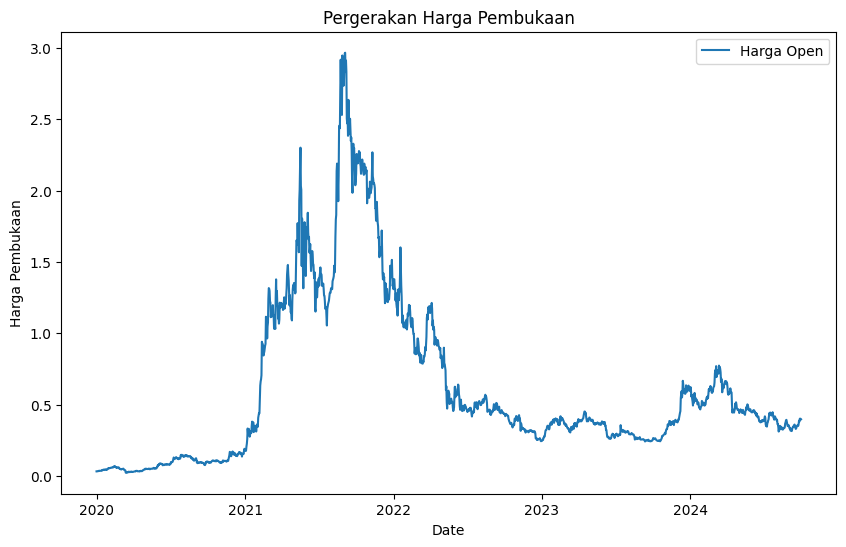

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Open'], label='Harga Open')
plt.xlabel('Date')
plt.ylabel('Harga Pembukaan')
plt.title('Pergerakan Harga Pembukaan')
plt.legend()
plt.show()

#### Pergerakan Harga Penutupan

/tmp/ipykernel_7496/3655211889.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_bulanan = df.resample('M').last()


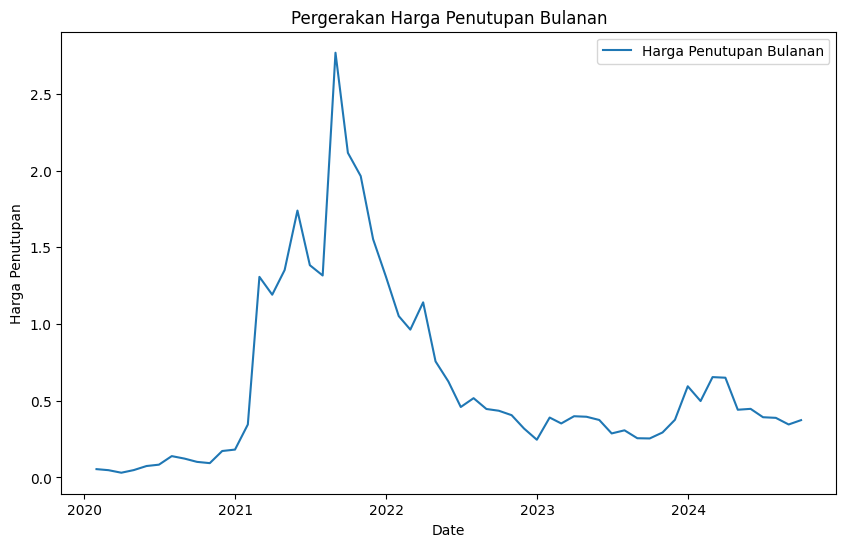

In [11]:
# Mengubah kolom 'Date' menjadi tipe datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Mengatur 'Date' sebagai index
df.set_index('Date', inplace=True)

# Mengubah data harian menjadi data bulanan dengan mengambil harga penutupan terakhir setiap bulan
df_bulanan = df.resample('M').last()

# Plot harga penutupan bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['Close'], label='Harga Penutupan Bulanan')
plt.xlabel('Date')
plt.ylabel('Harga Penutupan')
plt.title('Pergerakan Harga Penutupan Bulanan')
plt.legend()
plt.show()

#### Harga Penutupan MA 30

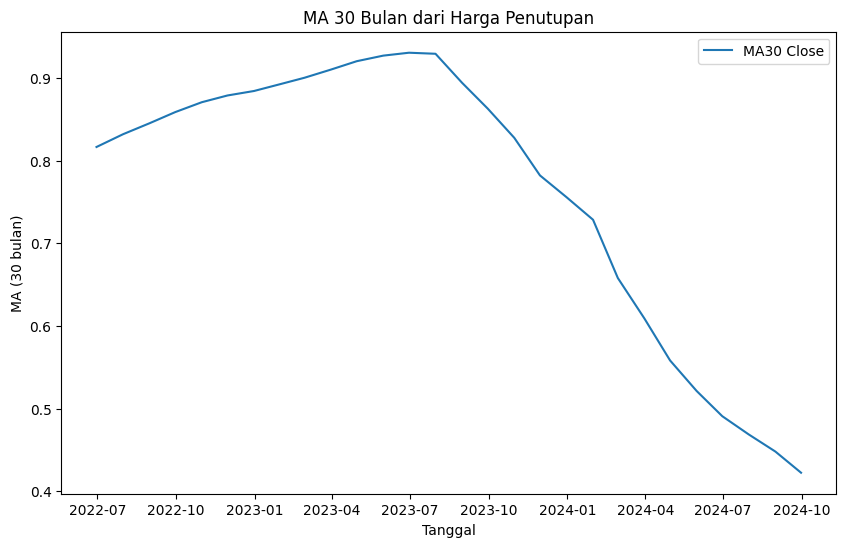

In [12]:
# Menghitung rata-rata bergerak (MA) untuk jendela 30 bulan
df_bulanan['MA30_Close'] = df_bulanan['Close'].rolling(window=30).mean()

# Plot rata-rata bergerak
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['MA30_Close'], label='MA30 Close')
plt.xlabel('Tanggal')
plt.ylabel('MA (30 bulan)')
plt.title('MA 30 Bulan dari Harga Penutupan')
plt.legend()
plt.show()

#### Harga Pembukaan MA 30

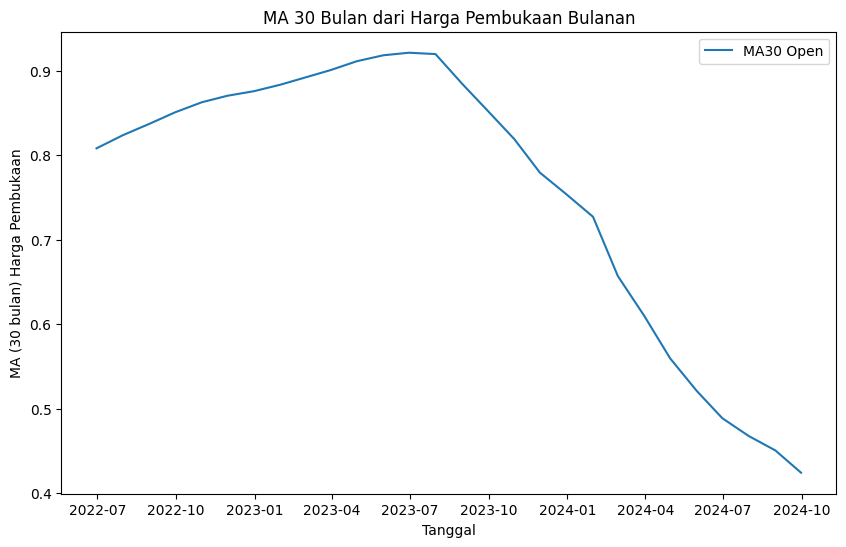

In [13]:
# Mengubah data harian menjadi data bulanan dengan mengambil harga pembukaan terakhir setiap bulan
df_bulanan['MA30_Open'] = df_bulanan['Open'].rolling(window=30).mean()

# Plot rata-rata bergerak harga pembukaan bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['MA30_Open'], label='MA30 Open')
plt.xlabel('Tanggal')
plt.ylabel('MA (30 bulan) Harga Pembukaan')
plt.title('MA 30 Bulan dari Harga Pembukaan Bulanan')
plt.legend()
plt.show()

#### Volatilitas Harian

/tmp/ipykernel_7496/142378207.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_bulanan['Volatilitas_Bulanan'] = df['daily_volatility'].resample('M').last()


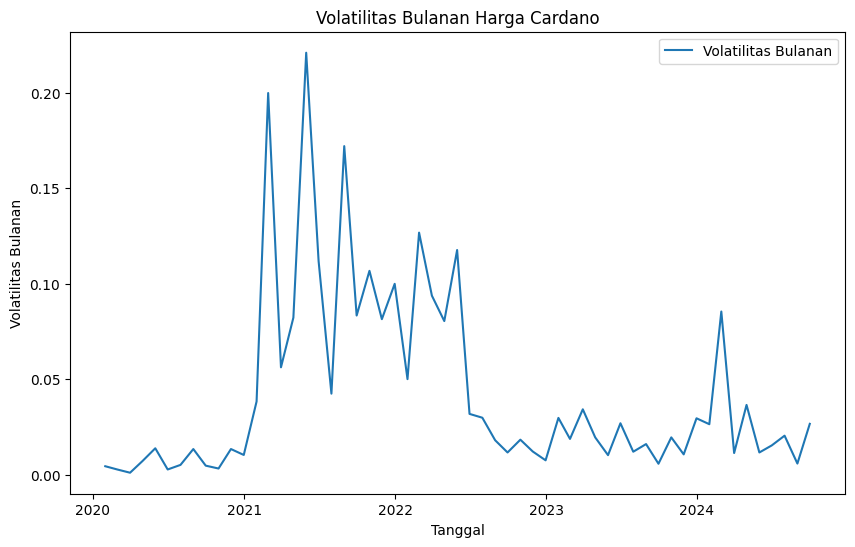

In [14]:
# Menambahkan kolom volatilitas harian
df['daily_volatility'] = df['High'] - df['Low']

# Mengubah data harian menjadi data bulanan dengan mengambil volatilitas harian terakhir setiap bulan
df_bulanan['Volatilitas_Bulanan'] = df['daily_volatility'].resample('M').last()

# Plot volatilitas bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['Volatilitas_Bulanan'], label='Volatilitas Bulanan')
plt.xlabel('Tanggal')
plt.ylabel('Volatilitas Bulanan')
plt.title('Volatilitas Bulanan Harga Cardano')
plt.legend()
plt.show()

#### Volume Perdangan

/tmp/ipykernel_7496/1629643273.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_bulanan['Volume_Bulanan'] = df['Volume'].resample('M').sum()


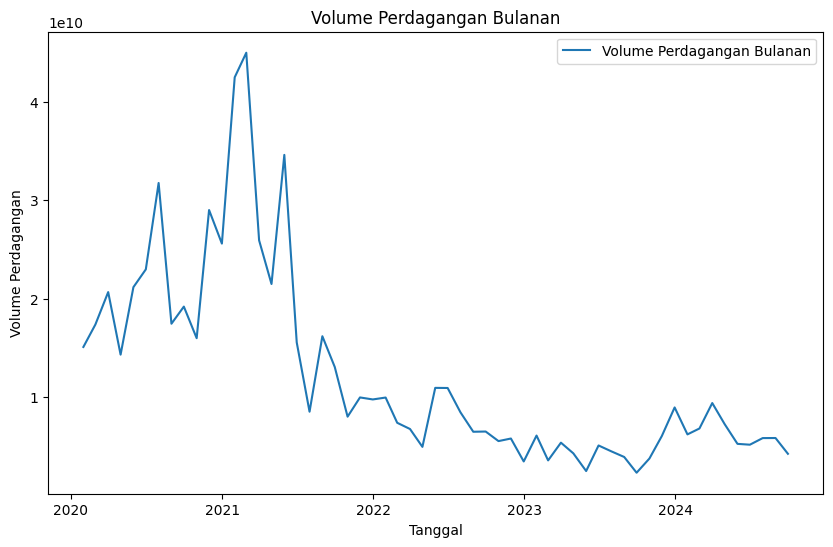

In [15]:
# Mengubah data harian menjadi data bulanan dengan menjumlahkan volume perdagangan setiap bulan
df_bulanan['Volume_Bulanan'] = df['Volume'].resample('M').sum()

# Plot volume perdagangan bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['Volume_Bulanan'], label='Volume Perdagangan Bulanan')
plt.xlabel('Tanggal')
plt.ylabel('Volume Perdagangan')
plt.title('Volume Perdagangan Bulanan')
plt.legend()
plt.show()

### Korelasi Antar Variabel

                     Close      Open      High       Low    Volume    Change  \
Close             1.000000  0.996477  0.998657  0.997674  0.046408  0.012080   
Open              0.996477  1.000000  0.998114  0.996847  0.041480 -0.048996   
High              0.998657  0.998114  1.000000  0.996172  0.061832 -0.012594   
Low               0.997674  0.996847  0.996172  1.000000  0.016858 -0.015539   
Volume            0.046408  0.041480  0.061832  0.016858  1.000000  0.156332   
Change            0.012080 -0.048996 -0.012594 -0.015539  0.156332  1.000000   
daily_volatility  0.729242  0.730996  0.751674  0.691147  0.384033  0.013115   

                  daily_volatility  
Close                     0.729242  
Open                      0.730996  
High                      0.751674  
Low                       0.691147  
Volume                    0.384033  
Change                    0.013115  
daily_volatility          1.000000  


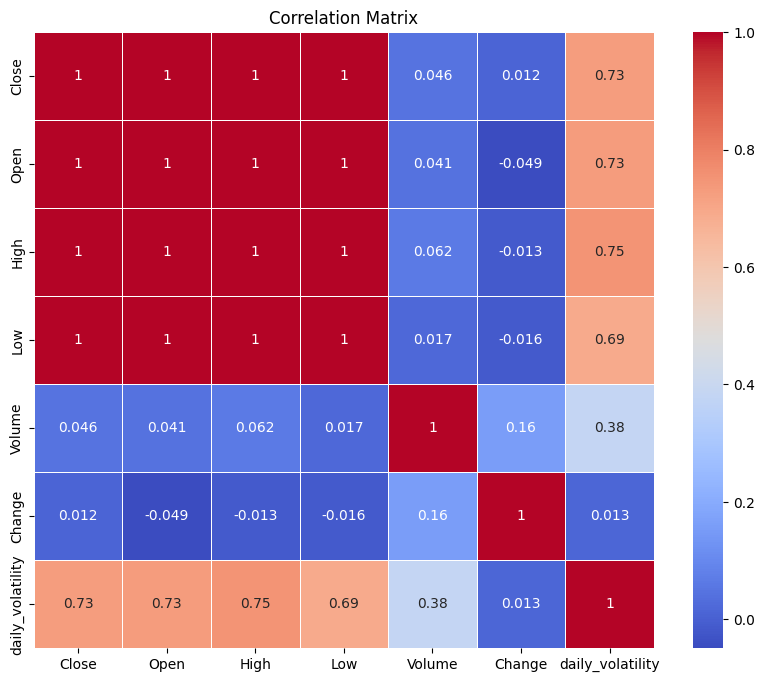

In [16]:
correlation_matrix = df.corr()

print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Pre-Processing Data

#### Seleksi Fitur

In [17]:
df.drop(columns=['Change', 'Volume'], inplace=True)
df.head()

,Close,Open,High,Low,daily_volatility
Date,,,,,
2024-09-30,0.3734,0.3976,0.3976,0.3709,0.0267
2024-09-29,0.3976,0.4006,0.4041,0.3927,0.0114
2024-09-28,0.4006,0.4017,0.4058,0.3924,0.0134
2024-09-27,0.4017,0.4016,0.4153,0.3999,0.0154
2024-09-26,0.4016,0.3811,0.4037,0.3782,0.0255


#### Penanganan Outlier

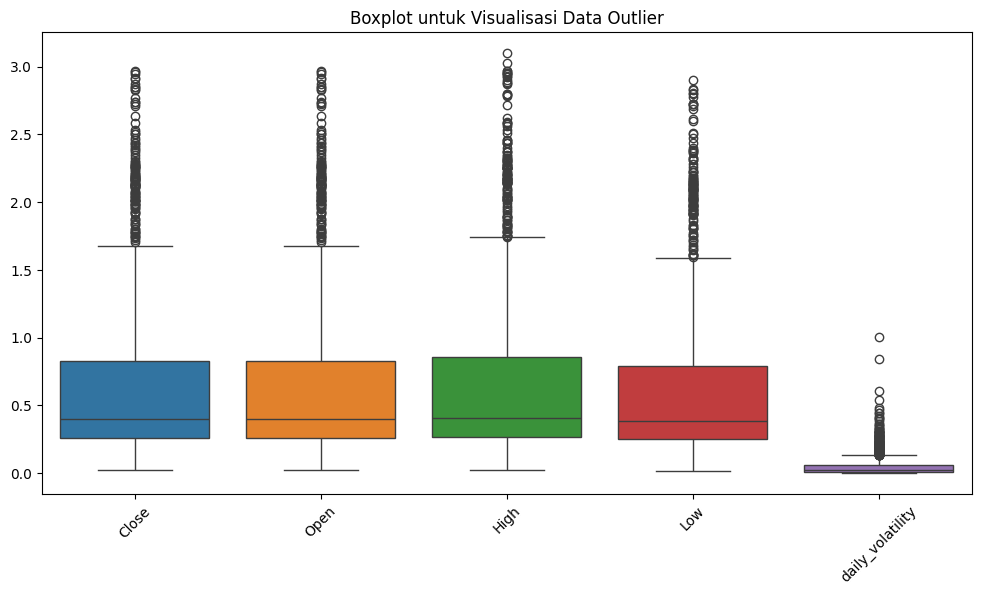

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Close', 'Open', 'High', 'Low', 'daily_volatility']])
plt.title('Boxplot untuk Visualisasi Data Outlier')
plt.xticks(rotation=45)
plt.show()

#### Menambah fitur

In [19]:
df['Month'] = np.arange(1,len(df)+1)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1735 entries, 2024-09-30 to 2020-01-01
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Close             1735 non-null   float64
 1   Open              1735 non-null   float64
 2   High              1735 non-null   float64
 3   Low               1735 non-null   float64
 4   daily_volatility  1735 non-null   float64
 5   Month             1735 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.9 KB


#### Normaliasi Data dengan Min-Max Scaling

## Modelling

### Alokasi Data Training dan Testing

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1735 entries, 2024-09-30 to 2020-01-01
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Close             1735 non-null   float64
 1   Open              1735 non-null   float64
 2   High              1735 non-null   float64
 3   Low               1735 non-null   float64
 4   daily_volatility  1735 non-null   float64
 5   Month             1735 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.9 KB


In [21]:
def create_sliding_window_features(df, window_size, target_columns):
    # Dataframe baru untuk menyimpan fitur sliding window
    sliding_features = pd.DataFrame(index=df.index)

    # Loop untuk setiap kolom target
    for col in target_columns:
        # Membuat fitur lag (sliding window) untuk setiap kolom
        for lag in range(1, window_size + 1):
            sliding_features[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # Drop missing values karena adanya shifting
    sliding_features = sliding_features.dropna()
    
    return sliding_features

In [22]:
# Kolom yang digunakan untuk sliding window (selain Date dan Month)
target_columns = ['Close', 'Open', 'High', 'Low', 'daily_volatility']
date_columns = ['Date', 'Month']

# Ukuran window (misal 12 hari)
window_size = 12

# Membuat dataset dengan fitur sliding window
df_sliding = create_sliding_window_features(df, window_size, target_columns)

# Menampilkan hasil
df_sliding.head()

,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Close_lag_8,Close_lag_9,Close_lag_10,...,daily_volatility_lag_3,daily_volatility_lag_4,daily_volatility_lag_5,daily_volatility_lag_6,daily_volatility_lag_7,daily_volatility_lag_8,daily_volatility_lag_9,daily_volatility_lag_10,daily_volatility_lag_11,daily_volatility_lag_12
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-18,0.3510,0.3522,0.3583,0.3517,0.3638,0.3876,0.3811,0.4016,0.4017,0.4006,...,0.0092,0.0160,0.0197,0.0330,0.0142,0.0255,0.0154,0.0134,0.0114,0.0267
2024-09-17,0.3438,0.3510,0.3522,0.3583,0.3517,0.3638,0.3876,0.3811,0.4016,0.4017,...,0.0122,0.0092,0.0160,0.0197,0.0330,0.0142,0.0255,0.0154,0.0134,0.0114
2024-09-16,0.3339,0.3438,0.3510,0.3522,0.3583,0.3517,0.3638,0.3876,0.3811,0.4016,...,0.0125,0.0122,0.0092,0.0160,0.0197,0.0330,0.0142,0.0255,0.0154,0.0134
2024-09-15,0.3302,0.3339,0.3438,0.3510,0.3522,0.3583,0.3517,0.3638,0.3876,0.3811,...,0.0165,0.0125,0.0122,0.0092,0.0160,0.0197,0.0330,0.0142,0.0255,0.0154
2024-09-14,0.3386,0.3302,0.3339,0.3438,0.3510,0.3522,0.3583,0.3517,0.3638,0.3876,...,0.0143,0.0165,0.0125,0.0122,0.0092,0.0160,0.0197,0.0330,0.0142,0.0255


In [25]:
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}, MAPE: {mape}")

# Evaluasi setiap model
evaluate_model(y_test, y_pred_dt, "Bagging Decision Tree Regressor")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test, y_pred_lr, "Bagging Linear Regressor")



Bagging Decision Tree Regressor - MSE: 0.0002736739558994198, RMSE: 0.016543093903481892, R-squared: 0.9992085353145198, MAPE: 0.00789056829848538
Random Forest Regressor - MSE: 0.0002451106460348171, RMSE: 0.0156560099014665, R-squared: 0.9992911403654242, MAPE: 0.007930924822900002
Bagging Linear Regressor - MSE: 1.5124414837784704e-06, RMSE: 0.0012298135971676644, R-squared: 0.9999956260214118, MAPE: 0.0008646936012861002


    Predicted_Close                      Month
0           0.03327 2024-10-31 09:29:17.823909
1           0.03404 2024-11-30 09:29:17.823909
2           0.03435 2024-12-31 09:29:17.823909
3           0.03432 2025-01-31 09:29:17.823909
4           0.03612 2025-02-28 09:29:17.823909
5           0.03760 2025-03-31 09:29:17.823909
6           0.03714 2025-04-30 09:29:17.823909
7           0.03496 2025-05-31 09:29:17.823909
8           0.03535 2025-06-30 09:29:17.823909
9           0.03566 2025-07-31 09:29:17.823909
10          0.03582 2025-08-31 09:29:17.823909
11          0.03175 2025-09-30 09:29:17.823909


/home/wchynto/media/data/Personal/Kuliah/PSD/prediksi-harga-cardano/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
/home/wchynto/media/data/Personal/Kuliah/PSD/prediksi-harga-cardano/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
/home/wchynto/media/data/Personal/Kuliah/PSD/prediksi-harga-cardano/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
/home/wchynto/media/data/Personal/Kuliah/PSD/prediksi-harga-cardano/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
/home/wchynto/media/data/Persona

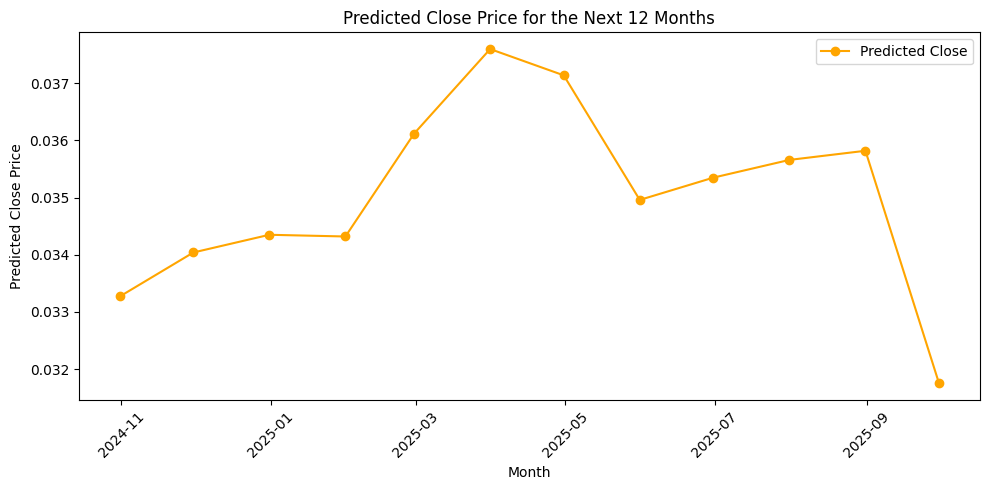

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Misalkan df_sliding sudah tersedia
# Pastikan kita memiliki data dari 12 bulan terakhir untuk prediksi

# 1. Dataframe Sliding Window
X = df_sliding.drop(columns=['Close_lag_1'])  # Mengambil fitur
y = df_sliding['Close_lag_1']  # Target

# 2. Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Melatih Model
dt_regressor = DecisionTreeRegressor()
bagging_dt = BaggingRegressor(estimator=dt_regressor, n_estimators=10, random_state=42)
bagging_dt.fit(X_train, y_train)

# 4. Melakukan prediksi untuk 12 bulan ke depan
# Mengambil data fitur terakhir untuk prediksi
latest_data = X.iloc[-1].values.reshape(1, -1)  # Ambil baris terakhir dari fitur dan reshape

predictions = []

for _ in range(12):  # Lakukan prediksi 12 kali (untuk 12 bulan ke depan)
    # Prediksi untuk bulan berikutnya
    next_pred = bagging_dt.predict(latest_data)[0]
    predictions.append(next_pred)
    
    # Siapkan data untuk prediksi berikutnya (sliding window)
    # Misalnya, kita menambahkan lag baru
    new_row = np.append(latest_data, next_pred)  # Tambahkan prediksi baru
    # Jika ada fitur lain, pastikan untuk memperbarui mereka di sini
    
    # Update latest_data untuk iterasi berikutnya
    latest_data = new_row[1:].reshape(1, -1)  # Mengambil semua kecuali prediksi baru

# Konversi hasil prediksi ke DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Predicted_Close'])
predictions_df['Month'] = pd.date_range(start=pd.to_datetime('today'), periods=12, freq='M')

# Menampilkan hasil prediksi
print(predictions_df)

# Visualisasi hasil prediksi
plt.figure(figsize=(10, 5))
plt.plot(predictions_df['Month'], predictions_df['Predicted_Close'], marker='o', color='orange', label='Predicted Close')
plt.title('Predicted Close Price for the Next 12 Months')
plt.xlabel('Month')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

